In [1]:
# Data Processing
import pandas as pd
import time


# Ignore the warnings if any
import warnings  
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler


# Load the dataset
df = pd.read_csv("../data/lab2_df.csv")
# define variables for classificaiton training

variables_ = ['age', 'fnlwgt', 'educationNum', 'hoursPerWeek', 'netCapital', 'isWhite', 'isMarried', 'isHusband', 'USA', 'sex_Male', 'jobtype_government', 'jobtype_other', 'jobtype_private']
y=df['income']
X=df[variables_]

# test train scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# prepare cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [46]:
from sklearn.metrics import accuracy_score,roc_curve,auc,precision_score,recall_score,f1_score,roc_auc_score

def evaluate(pre,pre_pro,y):
    acc=accuracy_score(y,pre)
    model_auc=roc_auc_score(y,pre)
    model_pre=precision_score(y,pre)
    model_recall=recall_score(y,pre)
    model_f1=f1_score(y,pre)
    fpr, tpr, thresholds =roc_curve(y,pre_pro[:,1])
    return acc,model_auc,model_pre,model_recall,model_f1,fpr,tpr


def model_eval(models):
    for name,model in models:
        print(name,'Start training...')
        model.fit(X_train,y_train)

        print("----{} Classifier Hyperparameter tuning Results ----".format(name))
        print("Best {} Score: {} ".format(name, model.best_score_))
        print("Best {} Parameters: {} ".format(name,model.best_params_))

        preds=model.predict(X_test)
        pro=model.predict_proba(X_test)
        acc,model_auc,model_pre,model_recall,model_f1,fpr,tpr=evaluate(preds,pro,y_test)

        start = time.time()
        model_results = cross_val_score(model, X_test, y_test,scoring='roc_auc',cv=kfold)
        end = time.time() - start
        print("")
        print("")
        print("Elapsed Time: %f" % (end))
        print("---- model selection ----")
        print("")
        print("{} Classifier test CV results: {}".format(name,model_results ))
        print("{} Classifier test MEAN CV results: {}".format(name,model_results.mean()))

        model_prediction = model.predict(X_test)
        print("")
        print("")
        print("---- Classification Report ----")
        print(classification_report(y_test, model_prediction))

        model_plot(fpr,tpr,name)

In [3]:

import matplotlib.pyplot as plt
def model_plot(fpr,tpr,name):
    #plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % model_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}_ROC'.format(name))
    plt.legend(loc="lower right")
    plt.savefig('{}_ROC.png'.format(name))
    plt.show()


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score, GridSearchCV


params_lr = {'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.1, 1, 10]}
lr_model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), params_lr, cv=kfold, scoring='roc_auc')

params_rfc = {'n_estimators': [50,100,150], 'max_depth':[5,20,10]}
rfc_model = GridSearchCV(RandomForestClassifier(), params_rfc, cv=kfold, scoring='roc_auc',n_jobs=-1)

params_nb = {'alpha': [1.0, 0.1, 0.01, 0.00], 'fit_prior':[True, False]}
nb_model = GridSearchCV(MultinomialNB(), params_nb, cv=kfold, scoring='roc_auc')


params_knn = {'n_neighbors': [17,15,19,21], 'weights':['uniform','distance'], 
              'metric':['minkowski','manhattan','chebyshev']}
knn_model = GridSearchCV(KNeighborsClassifier(), params_knn, cv=kfold, scoring='roc_auc',n_jobs=-1)

params_gbx = params = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          "max_depth":range(1, 11, 2),
         "objective":["binary:logistic"]}
gbx_model = GridSearchCV(XGBClassifier(), params_gbx, cv=kfold, scoring='roc_auc',n_jobs=-1)

LogisticRegression Start training...
----LogisticRegression Classifier Hyperparameter tuning Results ----
Best LogisticRegression Score: 0.8686701592631874 
Best LogisticRegression Parameters: {'C': 1, 'solver': 'sag'} 


Elapsed Time: 41.520306
---- model selection ----

LogisticRegression Classifier test CV results: [0.86365938 0.89234763 0.84004673 0.8753299  0.86297003 0.89124357
 0.84630593 0.86006764 0.86049688 0.87225546]
LogisticRegression Classifier test MEAN CV results: 0.86647231470502


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4966
           1       0.53      0.80      0.64      1547

    accuracy                           0.79      6513
   macro avg       0.73      0.79      0.74      6513
weighted avg       0.83      0.79      0.80      6513



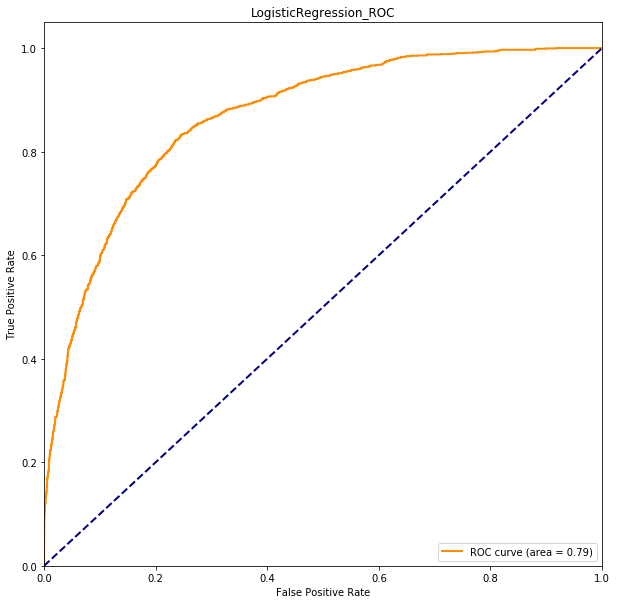

KNNClassifier Start training...
----KNNClassifier Classifier Hyperparameter tuning Results ----
Best KNNClassifier Score: 0.8637542443095839 
Best KNNClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'} 


Elapsed Time: 318.177782
---- model selection ----

KNNClassifier Classifier test CV results: [0.83427014 0.88464334 0.80484845 0.85937051 0.81934464 0.87231833
 0.82014828 0.84786681 0.83368887 0.85414932]
KNNClassifier Classifier test MEAN CV results: 0.8430648677801365


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      4966
           1       0.72      0.48      0.58      1547

    accuracy                           0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513



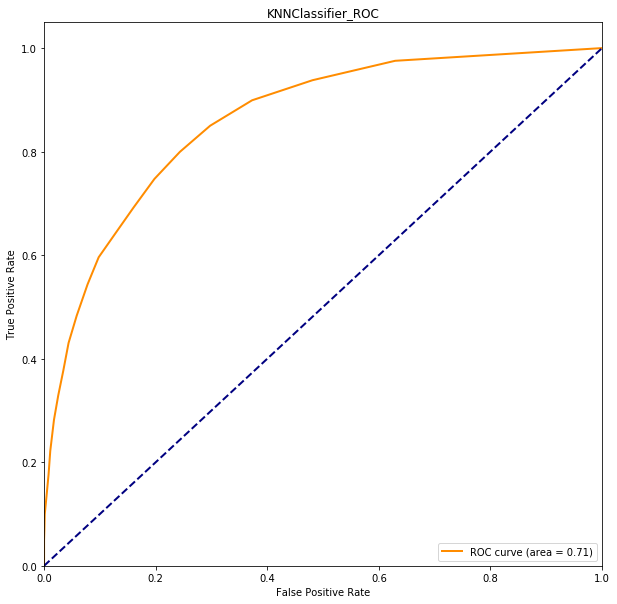

RandomForestClassifer Start training...
----RandomForestClassifer Classifier Hyperparameter tuning Results ----
Best RandomForestClassifer Score: 0.8950631829144058 
Best RandomForestClassifer Parameters: {'max_depth': 10, 'n_estimators': 100} 


Elapsed Time: 337.653548
---- model selection ----

RandomForestClassifer Classifier test CV results: [0.87061725 0.9188291  0.85198936 0.88262693 0.8784852  0.90943061
 0.86634365 0.8808988  0.87514958 0.88338319]
RandomForestClassifer Classifier test MEAN CV results: 0.8817753682112677


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4966
           1       0.80      0.49      0.61      1547

    accuracy                           0.85      6513
   macro avg       0.83      0.73      0.76      6513
weighted avg       0.84      0.85      0.84      6513



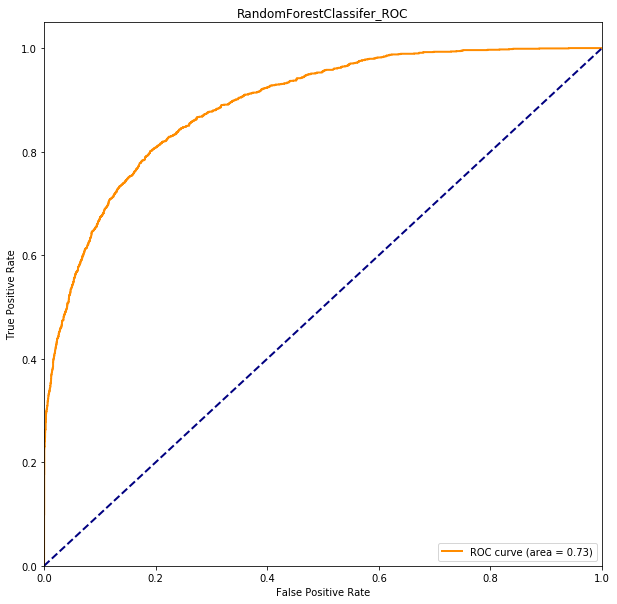

XGBClassifier Start training...
----XGBClassifier Classifier Hyperparameter tuning Results ----
Best XGBClassifier Score: 0.90808818242688 
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'} 


Elapsed Time: 1339.558055
---- model selection ----

XGBClassifier Classifier test CV results: [0.88187188 0.92467709 0.8664633  0.88998929 0.88330633 0.91045624
 0.88343522 0.89081686 0.88093132 0.88407258]
XGBClassifier Classifier test MEAN CV results: 0.8896020112322244


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4966
           1       0.77      0.56      0.65      1547

    accuracy                           0.86      6513
   macro avg       0.82      0.76      0.78      6513
weighted avg       0.85      0.86      0.85      6513



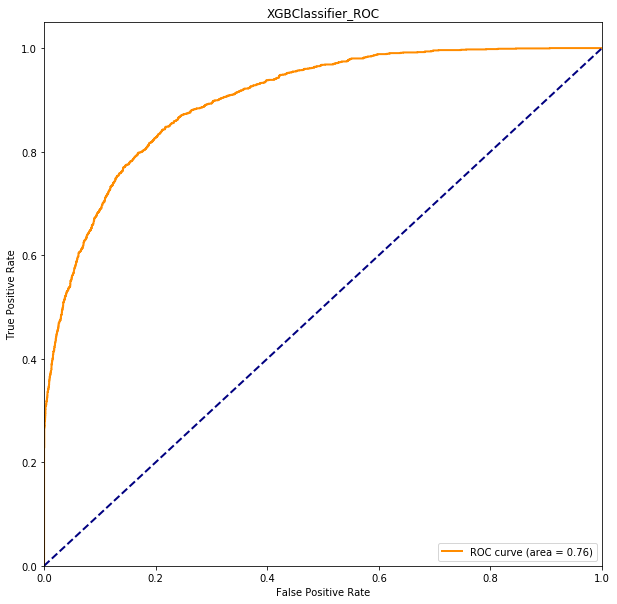

In [7]:
models=[('LogisticRegression',lr_model),
        ('KNNClassifier',knn_model),
        ('RandomForestClassifer',rfc_model),
        ('XGBClassifier',gbx_model)]

model_eval(models)

### Example on How to use These Results

In [5]:
"""
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'} 
"""

xgb_best = XGBClassifier(learning_rate=0.1, max_depth=7, objective='binary:logistic')
xgb_best.fit(X_train, y_train, eval_metric="auc")
xgb_best_results = cross_val_score(xgb_best, X_test, y_test,scoring='roc_auc',cv=kfold,  n_jobs=-1)
xgb_best_results

array([0.8741611 , 0.92235997, 0.85966119, 0.88923149, 0.87990279,
       0.90927382, 0.88283689, 0.88390999, 0.87710068, 0.8805346 ])

In [6]:
xgb_best.fit(X_train, y_train, eval_metric="auc")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [64]:
model_prediction = xgb_best.predict(X_test)
print("----XGBClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best XGBClassifier Score: 0.90808818242688")
print("Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}")
print("")
print("---- XGBClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----XGBClassifier Classifier Hyperparameter tuning Results ----

Best XGBClassifier Score: 0.90808818242688
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}

---- XGBClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4966
           1       0.77      0.56      0.65      1547

    accuracy                           0.86      6513
   macro avg       0.82      0.76      0.78      6513
weighted avg       0.85      0.86      0.85      6513



In [6]:
# summarize results
print("Best: %f using %s" % (xgb.best_score_, xgb.best_params_))
means = xgb.cv_results_['mean_test_score']
stds = xgb.cv_results_['std_test_score']
params = xgb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.860527 using {'learning_rate': 0.2, 'objective': 'binary:logistic'}
0.856535 (0.006213) with: {'learning_rate': 1, 'objective': 'binary:logistic'}
0.860527 (0.004334) with: {'learning_rate': 0.2, 'objective': 'binary:logistic'}
0.860373 (0.004043) with: {'learning_rate': 0.35, 'objective': 'binary:logistic'}
0.624759 (0.197373) with: {'learning_rate': 5, 'objective': 'binary:logistic'}


In [ ]:
[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],

__XGBoosting Classifier Learning Rate Hpyertuning__

In [71]:
xgb0001 = XGBClassifier(random_state=0, learning_rate=0.0001)
xgb0001.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.0001 ----")
print("xgb learning_rate=0.0001 Train accuracy: {:.3f}".format(cross_val_score(xgb0001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.0001 Test accuracy: {:.3f}".format(cross_val_score(xgb0001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

xgb001 = XGBClassifier(random_state=0, learning_rate=0.001)
xgb001.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.001 ----")
print("xgb learning_rate=0.001 Train accuracy: {:.3f}".format(cross_val_score(xgb001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.001 Test accuracy: {:.3f}".format(cross_val_score(xgb001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb01 = XGBClassifier(random_state=0, learning_rate=0.01)
xgb01.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.01 ----")
print("xgb learning_rate=0.001 Train accuracy: {:.3f}".format(cross_val_score(xgb01, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.001 Test accuracy: {:.3f}".format(cross_val_score(xgb01,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb1 = XGBClassifier(random_state=0, learning_rate=0.1)
xgb1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.1 ----")
print("xgb learning_rate=0.1 Train accuracy: {:.3f}".format(cross_val_score(xgb1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.1 Test accuracy: {:.3f}".format(cross_val_score(xgb1,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb2 = XGBClassifier(random_state=0, learning_rate=0.2)
xgb2.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.2 ----")
print("xgb learning_rate=0.2 Train accuracy: {:.3f}".format(cross_val_score(xgb2, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.2 Test accuracy: {:.3f}".format(cross_val_score(xgb2,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


xgb3 = XGBClassifier(random_state=0, learning_rate=0.3)
xgb3.fit(X_train, y_train)
print("")
print("---- Accuracy Results for learning_rate=0.3 ----")
print("xgb learning_rate=0.3 Train accuracy: {:.3f}".format(cross_val_score(xgb3, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("xgb learning_rate=0.3 Test accuracy: {:.3f}".format(cross_val_score(xgb3,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


---- Accuracy Results for learning_rate=0.0001 ----
xgb learning_rate=0.0001 Train accuracy: 0.837
xgb learning_rate=0.0001 Test accuracy: 0.833

---- Accuracy Results for learning_rate=0.001 ----
xgb learning_rate=0.001 Train accuracy: 0.838
xgb learning_rate=0.001 Test accuracy: 0.835

---- Accuracy Results for learning_rate=0.01 ----
xgb learning_rate=0.001 Train accuracy: 0.868
xgb learning_rate=0.001 Test accuracy: 0.865

---- Accuracy Results for learning_rate=0.1 ----
xgb learning_rate=0.1 Train accuracy: 0.901
xgb learning_rate=0.1 Test accuracy: 0.888

---- Accuracy Results for learning_rate=0.2 ----
xgb learning_rate=0.2 Train accuracy: 0.906
xgb learning_rate=0.2 Test accuracy: 0.889

---- Accuracy Results for learning_rate=0.3 ----
xgb learning_rate=0.3 Train accuracy: 0.908
xgb learning_rate=0.3 Test accuracy: 0.889


__XGB Classifier Analysis on Learning Rate Tuning (holding `max_depth` constant)__ 

Review the results from the XGB learning Rate tuning, we can see the test and train score outputs, and overall there does not appear to be any indication or evidenace of overfitting whith the addition of any of the experimented learning rates. With holding `max_depth` constant through each of the `learning_rate` tuning experiments, it appears tha as we increase the learning rate both test and train accuracy increases. Additionally, it appears the accuracy does level off after `learning_rate=0.1`, which is the same optimal value selected by the `GridSearchCV` tuning pipeline. 

__Further Tuning Analysis on learnigng_rate and max_depth__

In [72]:
params_gbx = params = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          "max_depth":range(1, 11, 2),
         "objective":["binary:logistic"]}

# Parallel Thread XGBoost and CV
xgb = GridSearchCV(estimator=XGBClassifier(),param_grid=params_gbx,cv=kfold, n_jobs=-1)
#xgb.fit(X_train_scaled,y_train, eval_metric="auc")
xgb.fit(X_train,y_train, eval_metric="auc")
print("----XGBoost Classifier Hyperparameter tuning Results ----")
print("Best XGBoost Score: ",xgb.best_score_)
print("Best XGBoost Parameters: ",xgb.best_params_)

# summarize results
print("")
print("----XGBoost Full EVAL on Trees, Max Depth and Learning Rate Hyperparameter tuning Results ----")
means = xgb.cv_results_['mean_test_score']
stds = xgb.cv_results_['std_test_score']
params = xgb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

----XGBoost Classifier Hyperparameter tuning Results ----
Best XGBoost Score:  0.8626381382842283
Best XGBoost Parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}

----XGBoost Full EVAL on Trees, Max Depth and Learning Rate Hyperparameter tuning Results ----
0.758369 (0.000176) with: {'learning_rate': 0.0001, 'max_depth': 1, 'objective': 'binary:logistic'}
0.839374 (0.004992) with: {'learning_rate': 0.0001, 'max_depth': 3, 'objective': 'binary:logistic'}
0.849662 (0.006016) with: {'learning_rate': 0.0001, 'max_depth': 5, 'objective': 'binary:logistic'}
0.852196 (0.005806) with: {'learning_rate': 0.0001, 'max_depth': 7, 'objective': 'binary:logistic'}
0.849393 (0.004339) with: {'learning_rate': 0.0001, 'max_depth': 9, 'objective': 'binary:logistic'}
0.758369 (0.000176) with: {'learning_rate': 0.001, 'max_depth': 1, 'objective': 'binary:logistic'}
0.839489 (0.005040) with: {'learning_rate': 0.001, 'max_depth': 3, 'objective': 'binary:logistic'}
0.850008 (0

__Analysis on Results of Tuning XGB on learnigng_rate and max_depth__

We can see the relationship between `max_depth` and `learning_rate`  has on the performance of the model. As the max_depth increases along with te learning rate, the complexity of the model is appropriately controlled indicating the corresponding increase in accuracy when tested on how well the parameters are able to generalized the responses. Therefore, the optimal value for XGB is `{'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic'}` for predicting INCOME.

In [12]:
import numpy as np
xgb_out = xgb_best.predict(X_test)
np.savetxt("./xgb_test_results.csv", xgb_out, delimiter=",")

Additionally, note the `class_weight = balances` where the `balanced` mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data  as ``n_samples / (n_classes * np.bincount(y))``.

LogisticRegression Start training...
----LogisticRegression Classifier Hyperparameter tuning Results ----
Best LogisticRegression Score: 0.8686722554900241 
Best LogisticRegression Parameters: {'C': 100, 'solver': 'sag'} 


Elapsed Time: 33.656516
---- model selection ----

LogisticRegression Classifier test CV results: [0.86365938 0.89220484 0.84004673 0.87531684 0.86297003 0.89124357
 0.84631894 0.86008065 0.86049688 0.87225546]
LogisticRegression Classifier test MEAN CV results: 0.8664593303975645


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4966
           1       0.53      0.80      0.64      1547

    accuracy                           0.79      6513
   macro avg       0.73      0.79      0.74      6513
weighted avg       0.83      0.79      0.80      6513



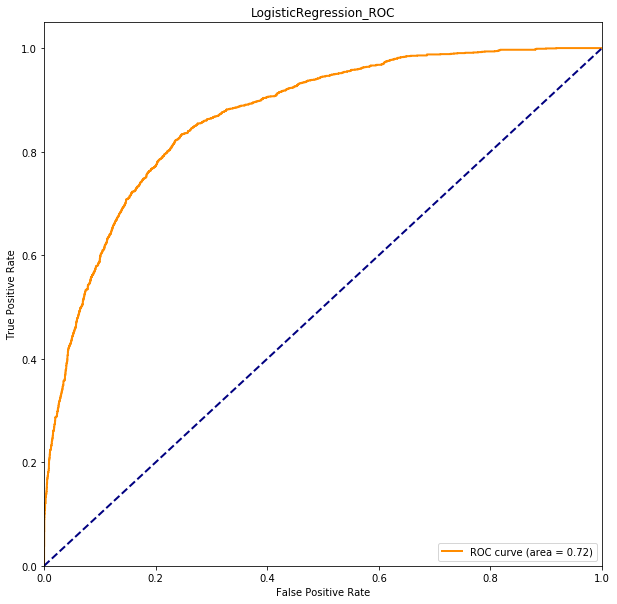

In [47]:
params_lr = {'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.001, 1, 100]}
lr_model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), params_lr, cv=kfold, scoring='roc_auc')

models=[('LogisticRegression',lr_model)]
model_eval(models)

BernoulliNB Start training...
----BernoulliNB Classifier Hyperparameter tuning Results ----
Best BernoulliNB Score: 0.8415793423611759 
Best BernoulliNB Parameters: {'alpha': 1.0, 'fit_prior': True} 


Elapsed Time: 3.982647
---- model selection ----

BernoulliNB Classifier test CV results: [0.83012267 0.87000065 0.79059518 0.83430453 0.82393713 0.8642439
 0.79622138 0.83316857 0.82683403 0.85491025]
BernoulliNB Classifier test MEAN CV results: 0.832433830247455


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4966
           1       0.60      0.56      0.58      1547

    accuracy                           0.81      6513
   macro avg       0.73      0.72      0.73      6513
weighted avg       0.80      0.81      0.81      6513



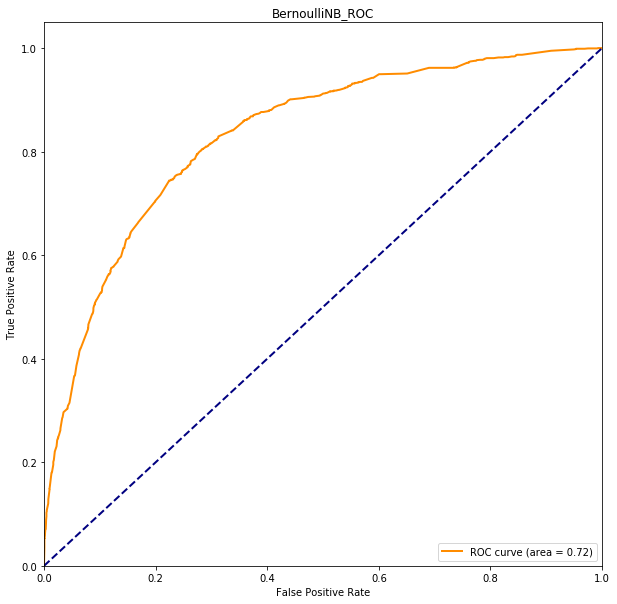

In [14]:
from sklearn.naive_bayes import BernoulliNB
params_nb = {'alpha': [1.0, 0.1, 0.01, 0.00], 'fit_prior':[True, False]}
nb_model = GridSearchCV(BernoulliNB(), params_nb, cv=kfold, scoring='roc_auc')

models=[('BernoulliNB',nb_model)]
model_eval(models)

In [65]:
model_prediction = nb.predict(X_test)
print("----BernoulliNB  Classifier Hyperparameter tuning Results ----")
print("")
print("Best BernoulliNB  Score: 0.8415793423611759")
print("Best BernoulliNB  Parameters: {'alpha': 1.0, 'fit_prior': True} ")
print("")
print("---- BernoulliNB Classification Report ----")
print(classification_report(y_test, model_prediction))

----BernoulliNB  Classifier Hyperparameter tuning Results ----

Best BernoulliNB  Score: 0.8415793423611759
Best BernoulliNB  Parameters: {'alpha': 1.0, 'fit_prior': True} 

---- BernoulliNB Classification Report ----
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4966
           1       0.60      0.56      0.58      1547

    accuracy                           0.81      6513
   macro avg       0.73      0.72      0.73      6513
weighted avg       0.80      0.81      0.81      6513



In [55]:
nb = BernoulliNB(alpha=1, fit_prior=True)
nb.fit(X_train, y_train)
print("Feature importances:\n{}".format(nb.feature_importances_))

AttributeError: 'BernoulliNB' object has no attribute 'feature_importances_'

In [56]:
nb.feature_count_

array([[7.7360e+03, 8.8020e+03, 4.8130e+03, 4.5990e+03, 8.0000e+02,
        1.6530e+04, 8.0000e+00, 5.8270e+03, 1.7555e+04, 1.2136e+04,
        2.4280e+03, 1.3310e+03, 1.4149e+04],
       [4.2640e+03, 2.6320e+03, 3.6610e+03, 3.1370e+03, 1.3320e+03,
        5.7090e+03, 8.0000e+00, 4.7760e+03, 5.7620e+03, 5.3680e+03,
        1.0770e+03, 1.5200e+02, 3.9570e+03]])

Feature importances:
[0.11573974 0.03123032 0.19643101 0.07790822 0.27755891 0.00530664
 0.0009495  0.25415906 0.00482168 0.02168478 0.0048792  0.00427329
 0.00505765]


In [66]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(max_depth=10, n_estimators=100)
tree.fit(X_train, y_train)
#print("Feature importances:\n{}".format(tree.feature_importances_))

model_prediction = tree.predict(X_test)
print("----RandomForestClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best RandomForestClassifier Score: 0.8950631829144058")
print("Best RandomForestClassifier Parameters: {'max_depth': 10, 'n_estimators': 100}")
print("")
print("---- RandomForestClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----RandomForestClassifier Classifier Hyperparameter tuning Results ----

Best RandomForestClassifier Score: 0.8950631829144058
Best RandomForestClassifier Parameters: {'max_depth': 10, 'n_estimators': 100}

---- RandomForestClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4966
           1       0.80      0.49      0.61      1547

    accuracy                           0.85      6513
   macro avg       0.83      0.72      0.76      6513
weighted avg       0.84      0.85      0.84      6513



In [32]:
print("Feature importances:\n{}".format(xgb_best.feature_importances_))

Feature importances:
[0.03678005 0.01112571 0.11309281 0.02491598 0.07842215 0.01795568
 0.01902794 0.6306095  0.01674954 0.01397893 0.01197422 0.01250163
 0.01286585]


In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=21,weights='uniform')
knn.fit(X_train, y_train)
#print("Feature importances:\n{}".format(knn.feature_importances_))
model_prediction = knn.predict(X_test)
print("----KNeighborsClassifier Classifier Hyperparameter tuning Results ----")
print("")
print("Best KNeighborsClassifier Score: 0.8637542443095839")
print("Best KNeighborsClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}")
print("")
print("---- KNeighborsClassifier Classification Report ----")
print(classification_report(y_test, model_prediction))

----KNeighborsClassifier Classifier Hyperparameter tuning Results ----

Best KNeighborsClassifier Score: 0.8637542443095839
Best KNeighborsClassifier Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}

---- KNeighborsClassifier Classification Report ----
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      4966
           1       0.72      0.48      0.58      1547

    accuracy                           0.83      6513
   macro avg       0.79      0.71      0.74      6513
weighted avg       0.82      0.83      0.82      6513



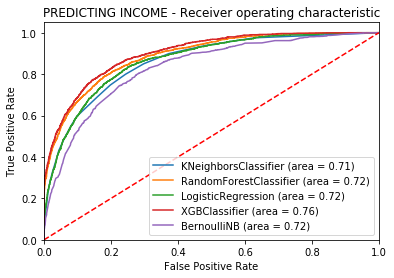

In [63]:
# https://github.com/naivelogic/Machine_Learning_Notebooks/blob/e0cf78b15c15f433d7d9d35dc7ad30cfe4d8cfda/Titanic%20Survival%20Prediction.ipynb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])

logit1_roc_auc = roc_auc_score(y_test, logit1.predict(X_test))
logit1_fpr, logit1_tpr, logit1_thresholds = roc_curve(y_test, logit1.predict_proba(X_test)[:,1])


xgb_best_roc_auc = roc_auc_score(y_test, xgb_best.predict(X_test))
xgb_best_fpr, xgb_best_tpr, xgb_best_thresholds = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])


nb_roc_auc = roc_auc_score(y_test, nb.predict(X_test))
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(knn_fpr, knn_tpr, label='KNeighborsClassifier (area = %0.2f)' % knn_roc_auc)
plt.plot(tree_fpr, tree_tpr, label='RandomForestClassifier (area = %0.2f)' % tree_roc_auc)

plt.plot(logit1_fpr, logit1_tpr, label='LogisticRegression (area = %0.2f)' % logit1_roc_auc)
plt.plot(xgb_best_fpr, xgb_best_tpr, label='XGBClassifier (area = %0.2f)' % xgb_best_roc_auc)
plt.plot(nb_fpr, nb_tpr, label='BernoulliNB (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PREDICTING INCOME - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Predicting_Income_ALL_ROC')

#### Feature Importance + Hyper Parameter Analysis - Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
logit1 = LogisticRegression(C=1, solver = 'sag')
logit1.fit(X_train, y_train)
model_prediction = logit1.predict(X_test)
print("----LogisticRegression Classifier Hyperparameter tuning Results ----")
print("")
print("Best LogisticRegression Score: 0.8686701592631874 ")
print("Best LogisticRegression Parameters: {'C': 1, 'solver': 'sag'} ")
print("")
print("---- LogisticRegression Classification Report ----")
print(classification_report(y_test, model_prediction))

----LogisticRegression Classifier Hyperparameter tuning Results ----

Best LogisticRegression Score: 0.8686701592631874 
Best LogisticRegression Parameters: {'C': 1, 'solver': 'sag'} 

---- LogisticRegression Classification Report ----
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4966
           1       0.71      0.50      0.59      1547

    accuracy                           0.83      6513
   macro avg       0.78      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



In [57]:
from sklearn.linear_model import LogisticRegression
logit001 = LogisticRegression(C=0.001, solver = 'sag')
logit001.fit(X_train, y_train)
print("---- Accuracy Results for C=0.001 ----")
print("logit C=0.001 Train accuracy: {:.3f}".format(cross_val_score(logit001, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=0.001 Test accuracy: {:.3f}".format(cross_val_score(logit001,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))


logit1 = LogisticRegression(C=1, solver = 'sag')
logit1.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=1 ----")
print("logit C=1 Train accuracy: {:.3f}".format(cross_val_score(logit1, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=1 Test accuracy: {:.3f}".format(cross_val_score(logit1, X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

logit100 = LogisticRegression(C=100, solver = 'sag')
logit100.fit(X_train, y_train)
print("")
print("---- Accuracy Results for C=100 ----")
print("logit C=100 Train accuracy: {:.3f}".format(cross_val_score(logit100, X_train, y_train,scoring='roc_auc',cv=kfold).mean()))
print("logit C=100 Test accuracy: {:.3f}".format(cross_val_score(logit100,  X_test, y_test,scoring='roc_auc',cv=kfold).mean()))

---- Accuracy Results for C=0.001 ----
logit C=0.001 Train accuracy: 0.862
logit C=0.001 Test accuracy: 0.852

---- Accuracy Results for C=1 ----
logit C=1 Train accuracy: 0.868
logit C=1 Test accuracy: 0.866

---- Accuracy Results for C=100 ----
logit C=100 Train accuracy: 0.868
logit C=100 Test accuracy: 0.866


__Analsyis on Tuning Hyperparameters:__ In the experiment above, we evaluate the `C` parameter, formally referred to as the __Inverse Regularization Parameter__ in which as we reviewed the plot above, the key indicator for our assessment is to review the smaller values that indicate the stronger regluarzation. This is important because here we can evaluate how well the regualrization parameter is controling the overfitting. 

The accuracy results show that as `C` increases the peformance on acuracy also increases, however it appears after C=1, that the logistic regression is stables and we do not see much change in the performance (better or worse), therefore, we can concluse that after `C=1` the model become obtimally regularized after increasing `C` may not improve the models ability to gernalize on more complex observations. 

#### Feature Importance - Logistic Regression

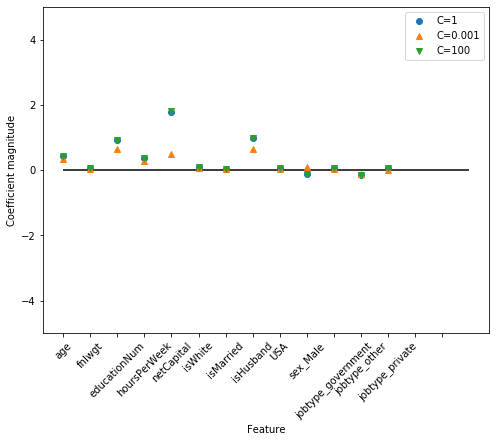

In [58]:
plt.figure(figsize=(8,6))
plt.plot(logit1.coef_.T, 'o', label="C=1")
plt.plot(logit001.coef_.T, '^', label="C=0.001")
plt.plot(logit100.coef_.T, 'v', label="C=100")
plt.xticks(range(df.shape[1]), variables_, rotation=45)
plt.hlines(0, 0, df.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
#plt.savefig('log_coef')

#print("Feature importances:\n{}".format(logit.feature_importances_))
#AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

__Analysis on Feature Importance - Logistic__
The plot above shows in the case for about all experiments with the Inverse Regularization Parameter that features `educaitonNum`, `netCapital` and `isHusband` appear to be solid features that are important to the model outcome.

In [54]:
def plot_feature_importances_(model):
    plt.figure(figsize=(8,6))
    n_features = 13
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), variables_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

#### [Income] Feature Importance - RandomForestClassifier

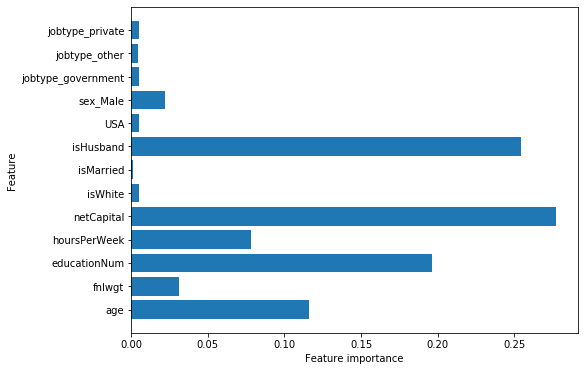

In [30]:
plot_feature_importances_(tree)
#plt.savefig('[income] feature_importance_RandomForestClassifier')

Reviewing the Feature Importance in the `RandomForestClassifier` we see similar important features that is also shared with te Logistic Regression model, where the following features proved to have the highest importance for predicting income when using the `RandomForestClassifier`:
* `isHusband`
* `netcapital`
* `hoursPerWeek`
* `educationNum`
* `age`

#### [Income] Feature Importance - XGBoost Classifier

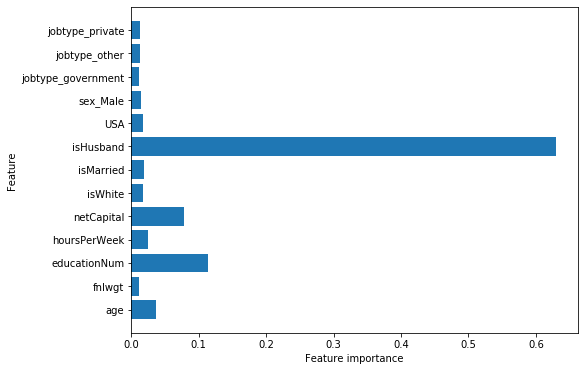

In [31]:
plot_feature_importances_(xgb_best)

Reviewing the Feature Importance in the `XGBoost Classifier` we see similar important features that is also shared with the other models experiments, most significatlly, XGBoost indicates that `isHusband` is by far this most important feature for predicting income. `educationNum` and `netCapital` come in a distance 2nd and 3rd important features. 

![](https://media.heartlandtv.com/images/census+bureau.png)

### Deployment

K

![](https://unitedwaynca.org/wp-content/uploads/2019/04/Census-2020-0411.png)

##### Deployment Strategy and Architecture
The Census Bureau is our target audience to deploy our process for data colleciton, analsyis, feature prediction as shown above to provide accurate results for the goverment to take aciton on. Our deployment strategy is to use a cloud hosting solution on Azure using a similar architecture for the Bureau teams to use at any remote location with a focus on security, privacy, data availablity and analytics offerings that Azure inherently provides:

![](https://www.znetlive.com/blog/wp-content/uploads/2017/08/machine-learning1.png)

This offering will be a cloud hosted where the backend SQL and Webservices hosting various dashboards and reporting tools tha can meet the scale and timliness the Census Buraru offers. 


##### Deployment Solutions, Usability, and Future Feature Enhancements
As we move into the 2020Census, our solution is best positioned to be pilotied with the Census Bureau to address seed to analsys, trend analysis and evaluation of new redsigns to determine whether certain new objective were met. Such goal, involves a recent redesign sa described in the expert from a census article below: 

![](https://image.slidesharecdn.com/censuspresentation-161111145704/95/census-2020-the-count-startsnow-36-638.jpg?cb=1478876267)

The Census Bureau has made changes to the way data is collected. With our solution and future implementation such as adding addiitonal datasets to follow-up feedback to obtain how valuable the questions and analysis are valuable to customers (e.g., citizens, organizations, schools, federal departments).

Moreover, provideing feedback system that we can provide sentiment anlaysis based off the results, we can provide those resposible metrics on which region, demographic has been identified with positive and negative input from the lates Census experiment. 

Additionally, another census article that was identified where researching more informaiton on the various data inputs and supporting processes to consider for the Census Bureau, we found these proposed draft changes to be of interest for future feature enhancements that can be offered to the Census Bureau: 

![](https://www.bing.com/th?id=OIP.TSSNbAyoJu1_UEtjaNUHcgHaEU&pid=Api&rs=1)


If additional datasets where incorporated and made available for our analysis, the deployed solution should be able to provide trend results to support additional reasources (e.g., addiditonal teaches allocated to increased population community areas). Additionally, the use of historical detail information that the bureau maintains, we can assist the internal employees to increase their productivity and evaluations. One enhanced feature that could be offered with additioal information on the population and perhaps combining datasets with the IRS is to provide employees that are responsible for various regious of the US to have dashboards that indicate the likelihood/or directly identifies if there are significant non-reported census in regions for follow-up activities to occur in those communities. 

__This would ensure that all communities provide unbias results and have an equal opportunity to be represented for goverment provided resources (e.g., schools, teachers, public resources, infrastructure fixes) based off an accurate representation of the communities census__
